In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
from timeit import default_timer
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, log_loss
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

In [11]:
!nvidia-smi

Thu May  4 03:16:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# MNIST

In [12]:
import torch
import torchvision

from torch.utils.data import DataLoader

In [13]:
dataset = torchvision.datasets.MNIST('./MNIST/train/', train=True, download=True,
        transform=torchvision.transforms.Compose([
          torchvision.transforms.ToTensor(),
          torchvision.transforms.Lambda(torch.flatten)
        #  torchvision.transforms.Normalize(
        #    (0.1307,), (0.3081,))
        ]))

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [2000, 58000])

train_loader = DataLoader(train_dataset, batch_size=2000)
test_loader = DataLoader(test_dataset, 58000)

In [14]:
train_examples = enumerate(train_loader)
_, (train_example_data, train_example_targets) = next(train_examples)
X_train = train_example_data.numpy()
y_train = train_example_targets.numpy()

test_examples = enumerate(test_loader)
_, (test_example_data, test_example_targets) = next(test_examples)
X_test = test_example_data.numpy() 
y_test = test_example_targets.numpy()

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2000, 784) (58000, 784) (2000,) (58000,)


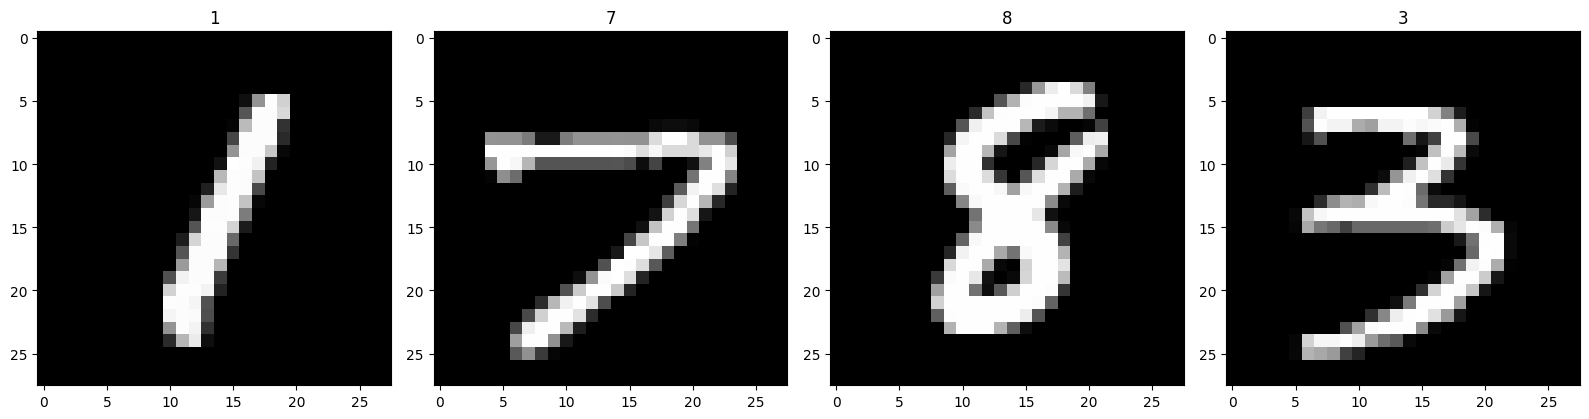

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
ax1.set_title(y_train[0])
ax1.imshow(X_train[0].reshape(28, 28), cmap='gray')

ax2.set_title(y_train[1])
ax2.imshow(X_train[1].reshape(28, 28), cmap='gray')

ax3.set_title(y_train[2])
ax3.imshow(X_train[2].reshape(28, 28), cmap='gray')

ax4.set_title(y_train[3])
ax4.imshow(X_train[3].reshape(28, 28), cmap='gray')

plt.tight_layout()

## Sklearn Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

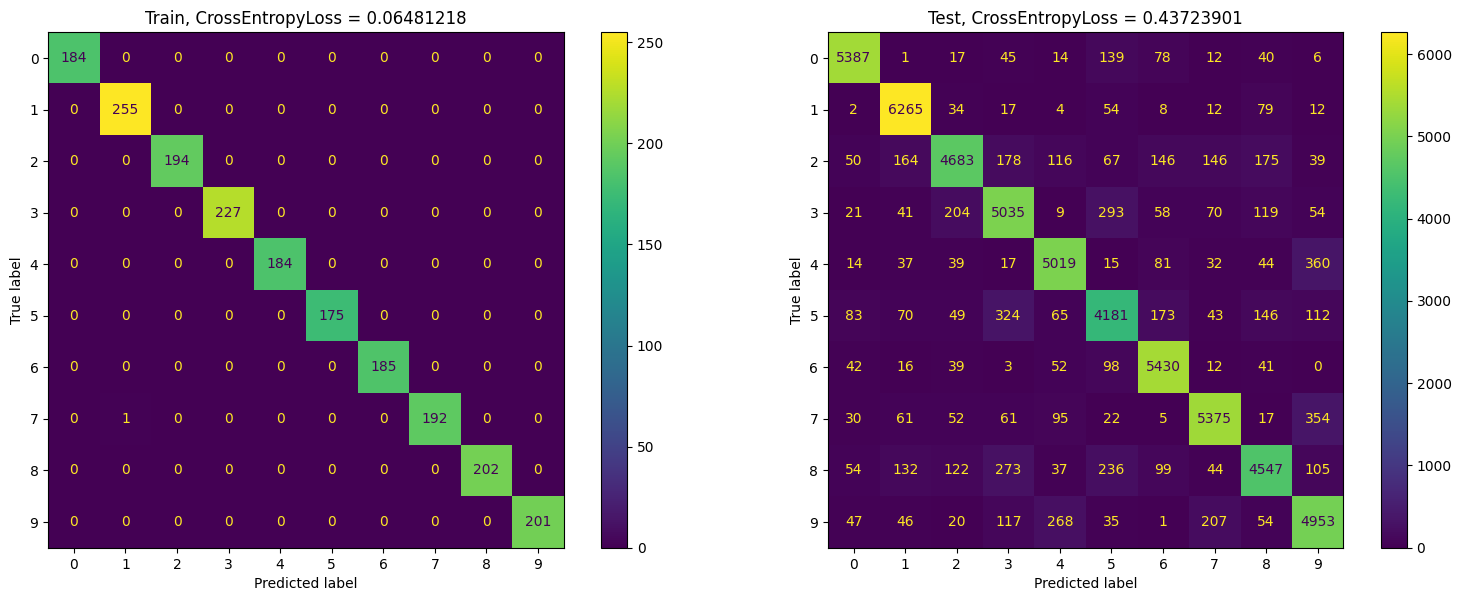

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

y_pred = clf.predict(X_train)
loss = log_loss(y_train, clf.predict_proba(X_train))
cm = confusion_matrix(y_train, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot(ax=axs[0])
axs[0].set_title(f'Train, CrossEntropyLoss = {round(loss, 8)}')

y_pred = clf.predict(X_test)
loss = log_loss(y_test, clf.predict_proba(X_test))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot(ax=axs[1])
axs[1].set_title(f'Test, CrossEntropyLoss = {round(loss, 8)}')

plt.tight_layout()

## Pytorch NN Logistic Regression

In [20]:
import torch

import torchvision.transforms as T
from torch.utils.data import TensorDataset
from torch.utils.data import Subset

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [22]:
!nvidia-smi

Thu May  4 03:19:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [36]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [2000, 200, 57800])

train_loader = DataLoader(train_dataset, batch_size=200)
val_loader = DataLoader(val_dataset, batch_size=200)
test_loader = DataLoader(test_dataset, batch_size=200)

In [29]:
class Logistic_Regression(torch.nn.Module):
    def __init__(self, in_size=784, out_size=10):
        super().__init__()
        self.layers = torch.nn.Sequential(
                torch.nn.Linear(in_size, out_size),
            )
    
    def forward(self, x):
        return self.layers(x)

In [30]:
def train(model, criterion, optimizer, n_epochs, n_stop=10):
    train_loss = list()
    val_loss = list()
    min_val_loss = np.inf
    f = 0
    t0 = default_timer()
    for epoch in range(n_epochs):
        t1 = default_timer()
        model.train()
        train_batch_loss = list()
        for batch in train_loader:
            optimizer.zero_grad()
            _X, _y = batch
            _X, _y = _X.to(device), _y.to(device)
            _y_pred = model(_X)
            loss = criterion(_y_pred, _y)
            loss.backward()
            optimizer.step()
            train_batch_loss.append(loss.item())

        model.eval()
        val_batch_loss = list()
        for batch in val_loader:
            _X, _y = batch
            _X, _y = _X.to(device), _y.to(device)
            _y_pred = model(_X)
            loss = criterion(_y_pred, _y)
            val_batch_loss.append(loss.item())

        t2 = default_timer()

        if epoch % 10 == 0:
            print(f'Epoch: {epoch} ({round(t2-t1, 3)}s, {round(t2-t0, 3)}s), \tTrain loss: {np.mean(train_batch_loss).round(3)}, \tValidation loss: {np.mean(val_batch_loss).round(3)}')
        train_loss.append(np.mean(train_batch_loss))
        val_loss.append(np.mean(val_batch_loss))

        # (optional) early stopping:

        if round(val_loss[-1], 3) >= min_val_loss:
            f = f + 1
        else:
            # print(f'epoch: {epoch}, val loss did decrease, saving model')
            f = 0
            best_model = deepcopy(model)
            min_val_loss = round(val_loss[-1], 3)
        if f >= n_stop:
            print(f'epoch: {epoch}, val loss did not decrease for {f} epoch(s)')
            break

    return best_model, train_loss, val_loss

In [31]:
model = Logistic_Regression().to(device)

criterion = torch.nn.CrossEntropyLoss()

alpha = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=alpha, weight_decay=0.03)

model, train_loss, val_loss = train(model, criterion, optimizer, n_epochs=10000, n_stop=10)

Epoch: 0 (0.337s, 0.337s), 	Train loss: 2.135, 	Validation loss: 1.922
Epoch: 10 (0.503s, 4.232s), 	Train loss: 0.747, 	Validation loss: 0.775
Epoch: 20 (0.309s, 8.351s), 	Train loss: 0.59, 	Validation loss: 0.645
Epoch: 30 (0.309s, 11.489s), 	Train loss: 0.541, 	Validation loss: 0.605
Epoch: 40 (0.43s, 14.983s), 	Train loss: 0.521, 	Validation loss: 0.589
Epoch: 50 (0.306s, 18.434s), 	Train loss: 0.511, 	Validation loss: 0.581
Epoch: 60 (0.31s, 21.634s), 	Train loss: 0.506, 	Validation loss: 0.577
Epoch: 70 (0.309s, 24.744s), 	Train loss: 0.504, 	Validation loss: 0.575
Epoch: 80 (0.361s, 28.475s), 	Train loss: 0.502, 	Validation loss: 0.574
epoch: 85, val loss did not decrease for 10 epoch(s)


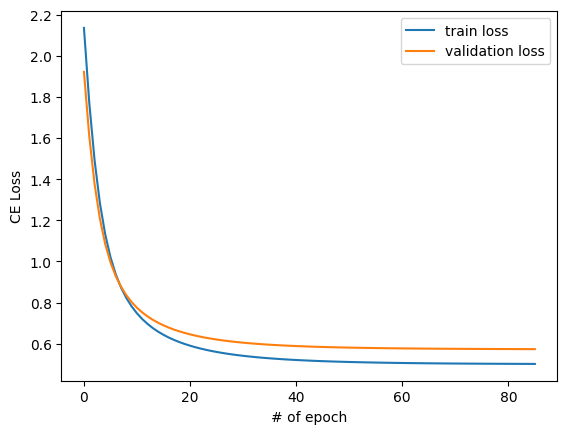

In [32]:
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.legend()
plt.ylabel('CE Loss')
plt.xlabel('# of epoch')
plt.show()

In [91]:
def plot_loader(loader, ax):
    model.to('cpu')
    total_target = list()
    total_pred = list()
    for batch in loader:
        example_data, example_targets = batch
        example_data = example_data.cpu()
        example_targets = example_targets.cpu()
        y_pred = model(example_data)
        total_target.append(example_targets)
        total_pred.append(y_pred)
    total_target = torch.hstack(total_target)
    total_pred = torch.vstack(total_pred).softmax(dim=1)
    # print(total_pred, total_pred.shape, total_target, total_target.shape)
    loss = log_loss(total_target, total_pred)
    cm = confusion_matrix(total_target, torch.argmax(total_pred, axis=1))
    cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax)
    return loss

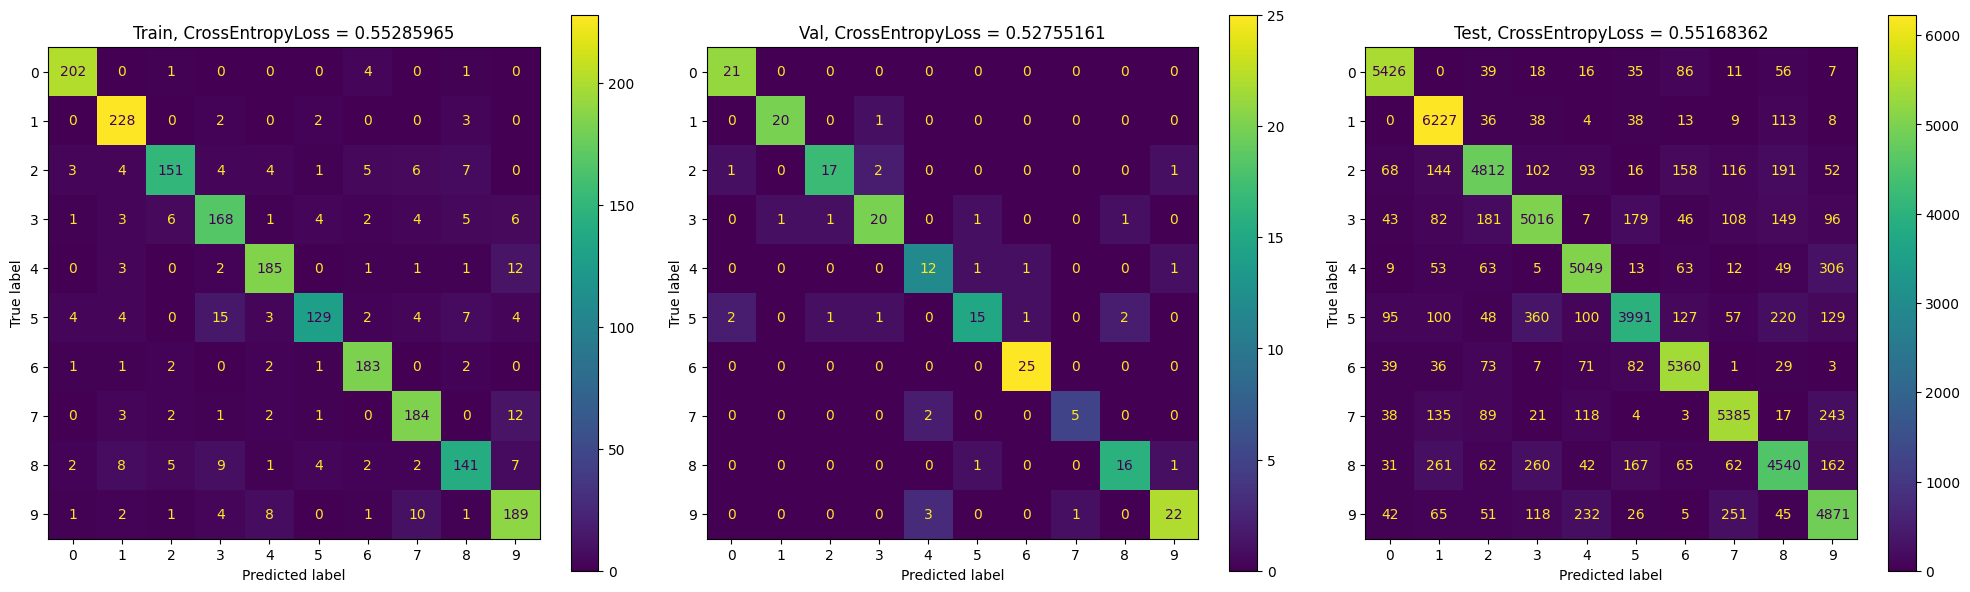

In [92]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

with torch.no_grad():
    model.to('cpu')

    loss = plot_loader(train_loader, ax=axs[0])
    axs[0].set_title(f'Train, CrossEntropyLoss = {round(loss, 8)}')

    loss = plot_loader(val_loader, ax=axs[1])
    axs[1].set_title(f'Val, CrossEntropyLoss = {round(loss, 8)}')

    loss = plot_loader(test_loader, ax=axs[2])
    axs[2].set_title(f'Test, CrossEntropyLoss = {round(loss, 8)}')

plt.tight_layout()

In [93]:
!nvidia-smi

Thu May  4 03:46:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    29W /  70W |    823MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Convolutional Neural Network

In [94]:
dataset = torchvision.datasets.MNIST('./MNIST/train/', train=True, download=True,
        transform=torchvision.transforms.Compose([
          torchvision.transforms.ToTensor(),
        #  torchvision.transforms.Lambda(torch.flatten)
        #  torchvision.transforms.Normalize(
        #    (0.1307,), (0.3081,))
        ]))

In [95]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [2000, 200, 57800])

train_loader = DataLoader(train_dataset, batch_size=200)
val_loader = DataLoader(val_dataset, batch_size=200)
test_loader = DataLoader(test_dataset, batch_size=200)

In [96]:
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary

In [97]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1,3*3*64)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [98]:
model = CNN()
model.cuda()
examples = enumerate(train_loader)
_, (example_data, example_targets) = next(examples)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
            Conv2d-2           [-1, 32, 20, 20]          25,632
            Conv2d-3             [-1, 64, 6, 6]          51,264
            Linear-4                  [-1, 256]         147,712
            Linear-5                   [-1, 10]           2,570
Total params: 228,010
Trainable params: 228,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 0.87
Estimated Total Size (MB): 1.13
----------------------------------------------------------------


In [99]:
model = CNN().to(device)
model.cuda()

criterion = torch.nn.CrossEntropyLoss()

alpha = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=alpha, weight_decay=0.03)

model, train_loss, val_loss = train(model, criterion, optimizer, n_epochs=10000, n_stop=10)

Epoch: 0 (1.109s, 1.109s), 	Train loss: 2.292, 	Validation loss: 2.261
Epoch: 10 (0.364s, 4.836s), 	Train loss: 0.351, 	Validation loss: 0.198
Epoch: 20 (0.47s, 8.834s), 	Train loss: 0.271, 	Validation loss: 0.136
Epoch: 30 (0.378s, 12.836s), 	Train loss: 0.245, 	Validation loss: 0.158
epoch: 30, val loss did not decrease for 10 epoch(s)


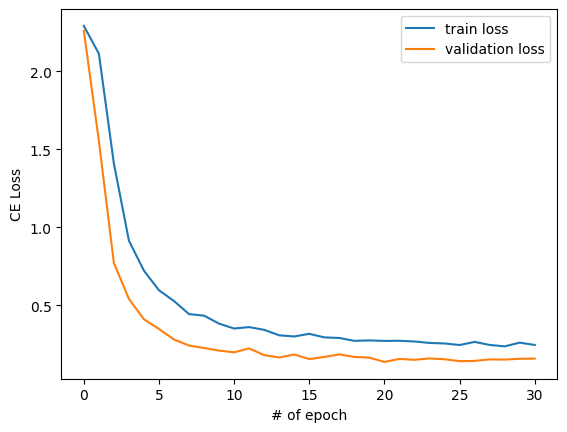

In [100]:
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.legend()
plt.ylabel('CE Loss')
plt.xlabel('# of epoch')
plt.show()

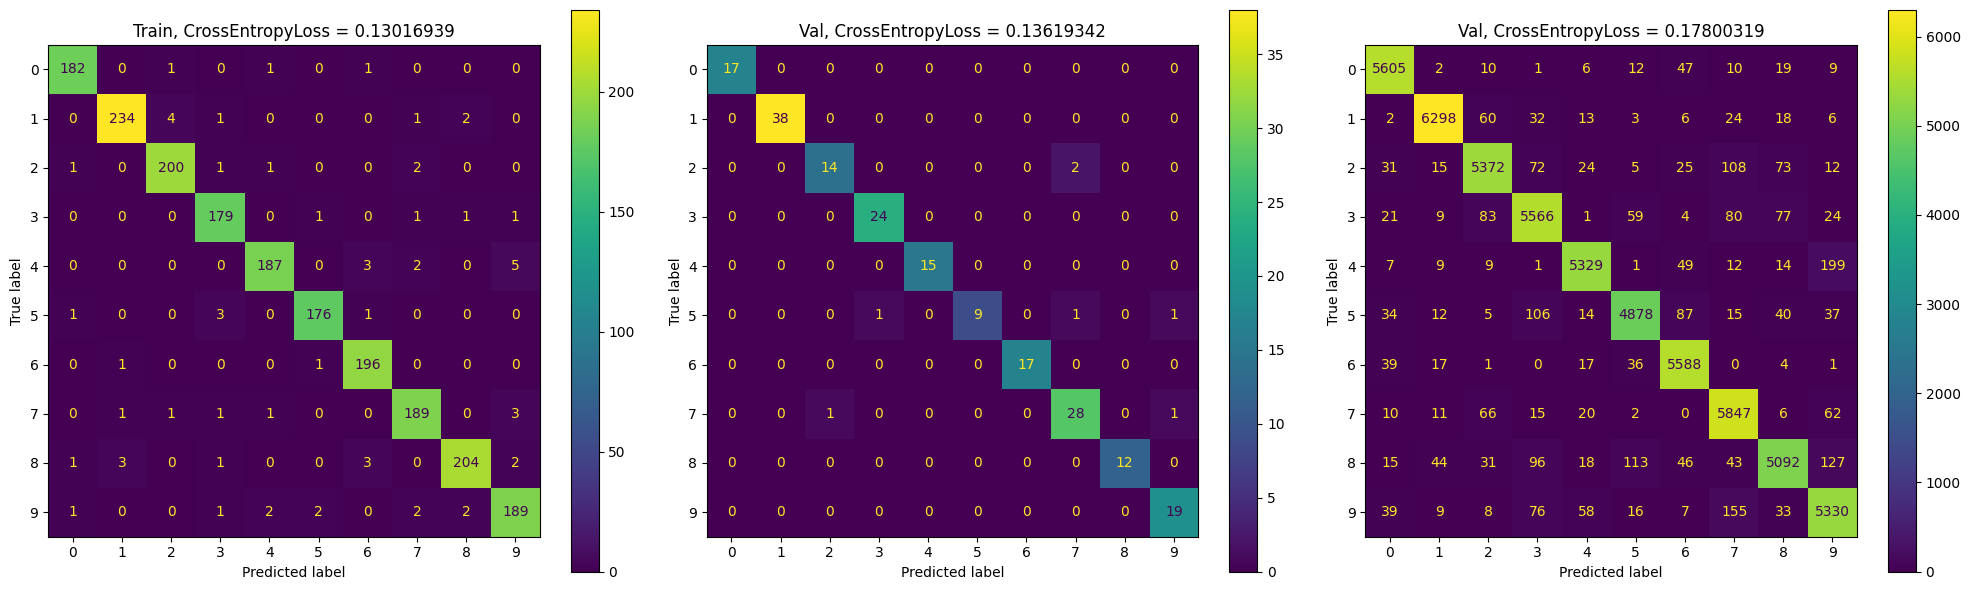

In [101]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

with torch.no_grad():
    model.to('cpu')

    loss = plot_loader(train_loader, ax=axs[0])
    axs[0].set_title(f'Train, CrossEntropyLoss = {round(loss, 8)}')

    loss = plot_loader(val_loader, ax=axs[1])
    axs[1].set_title(f'Val, CrossEntropyLoss = {round(loss, 8)}')

    loss = plot_loader(test_loader, ax=axs[2])
    axs[2].set_title(f'Val, CrossEntropyLoss = {round(loss, 8)}')

plt.tight_layout()

## Outputs of convolution layers

In [102]:
examples = enumerate(test_loader)
_, (example_data, example_targets) = next(examples)

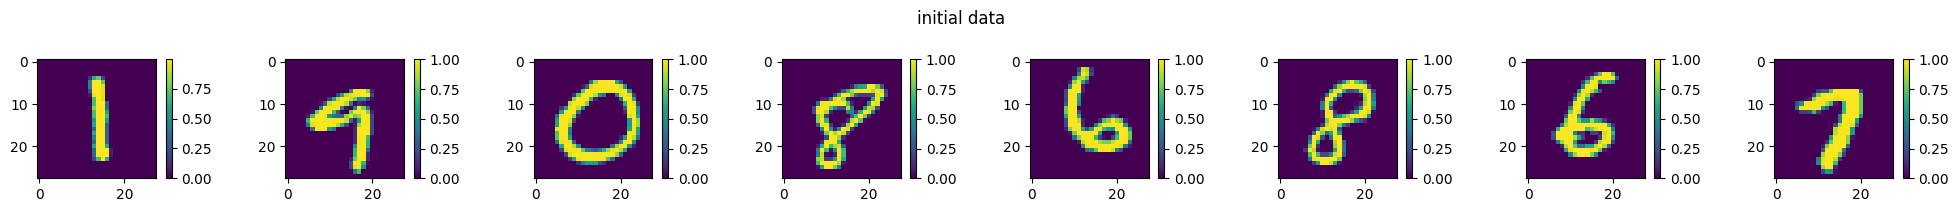

In [103]:
fig, axs = plt.subplots(1, 8, figsize=(20, 2))

plt.suptitle('initial data')
for i, ax in enumerate(axs):
    sc = ax.imshow(example_data[i, 0])
    fig.colorbar(sc, ax=ax)
plt.tight_layout()

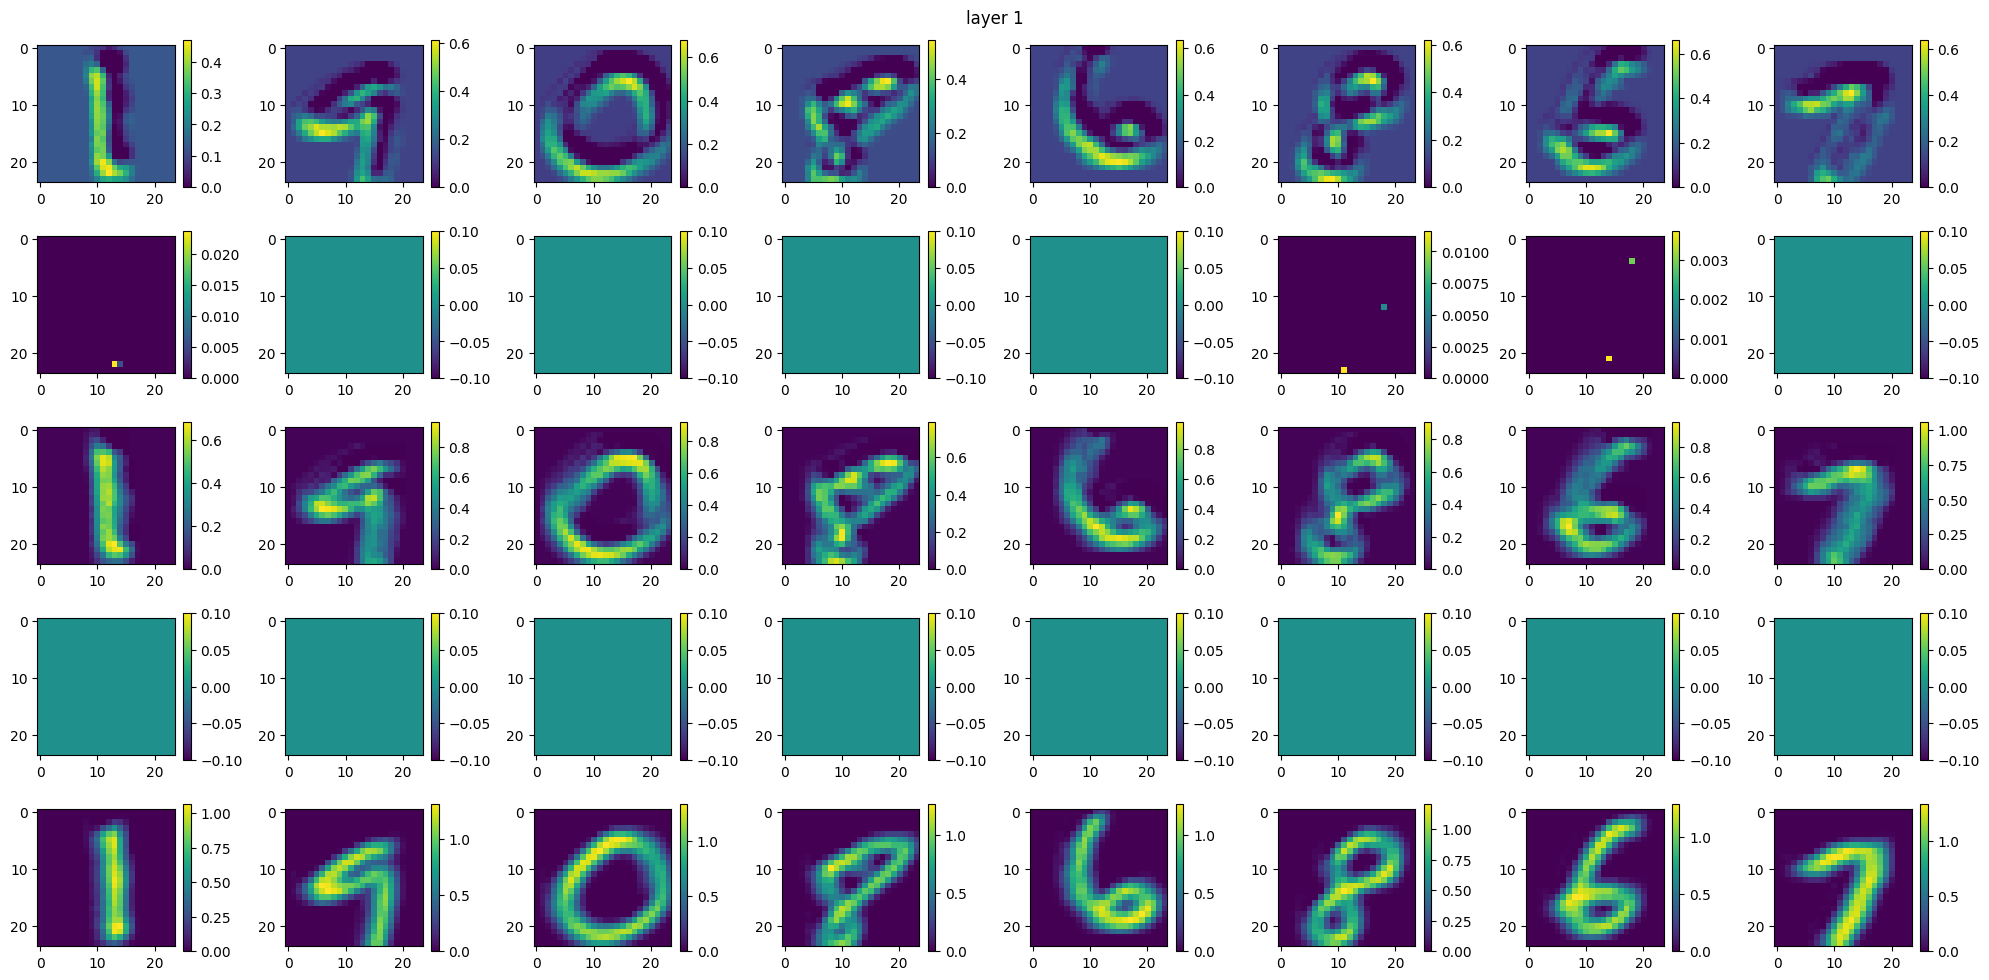

In [104]:
fig, axs = plt.subplots(5, 8, figsize=(20, 10))

plt.suptitle('layer 1')
data = F.relu(model.conv1(example_data))
for i in range(5):
    for j in range(8):
        ax = axs[i, j]
        sc = ax.imshow(data[j, i].detach().numpy())
        fig.colorbar(sc, ax=ax)
plt.tight_layout()

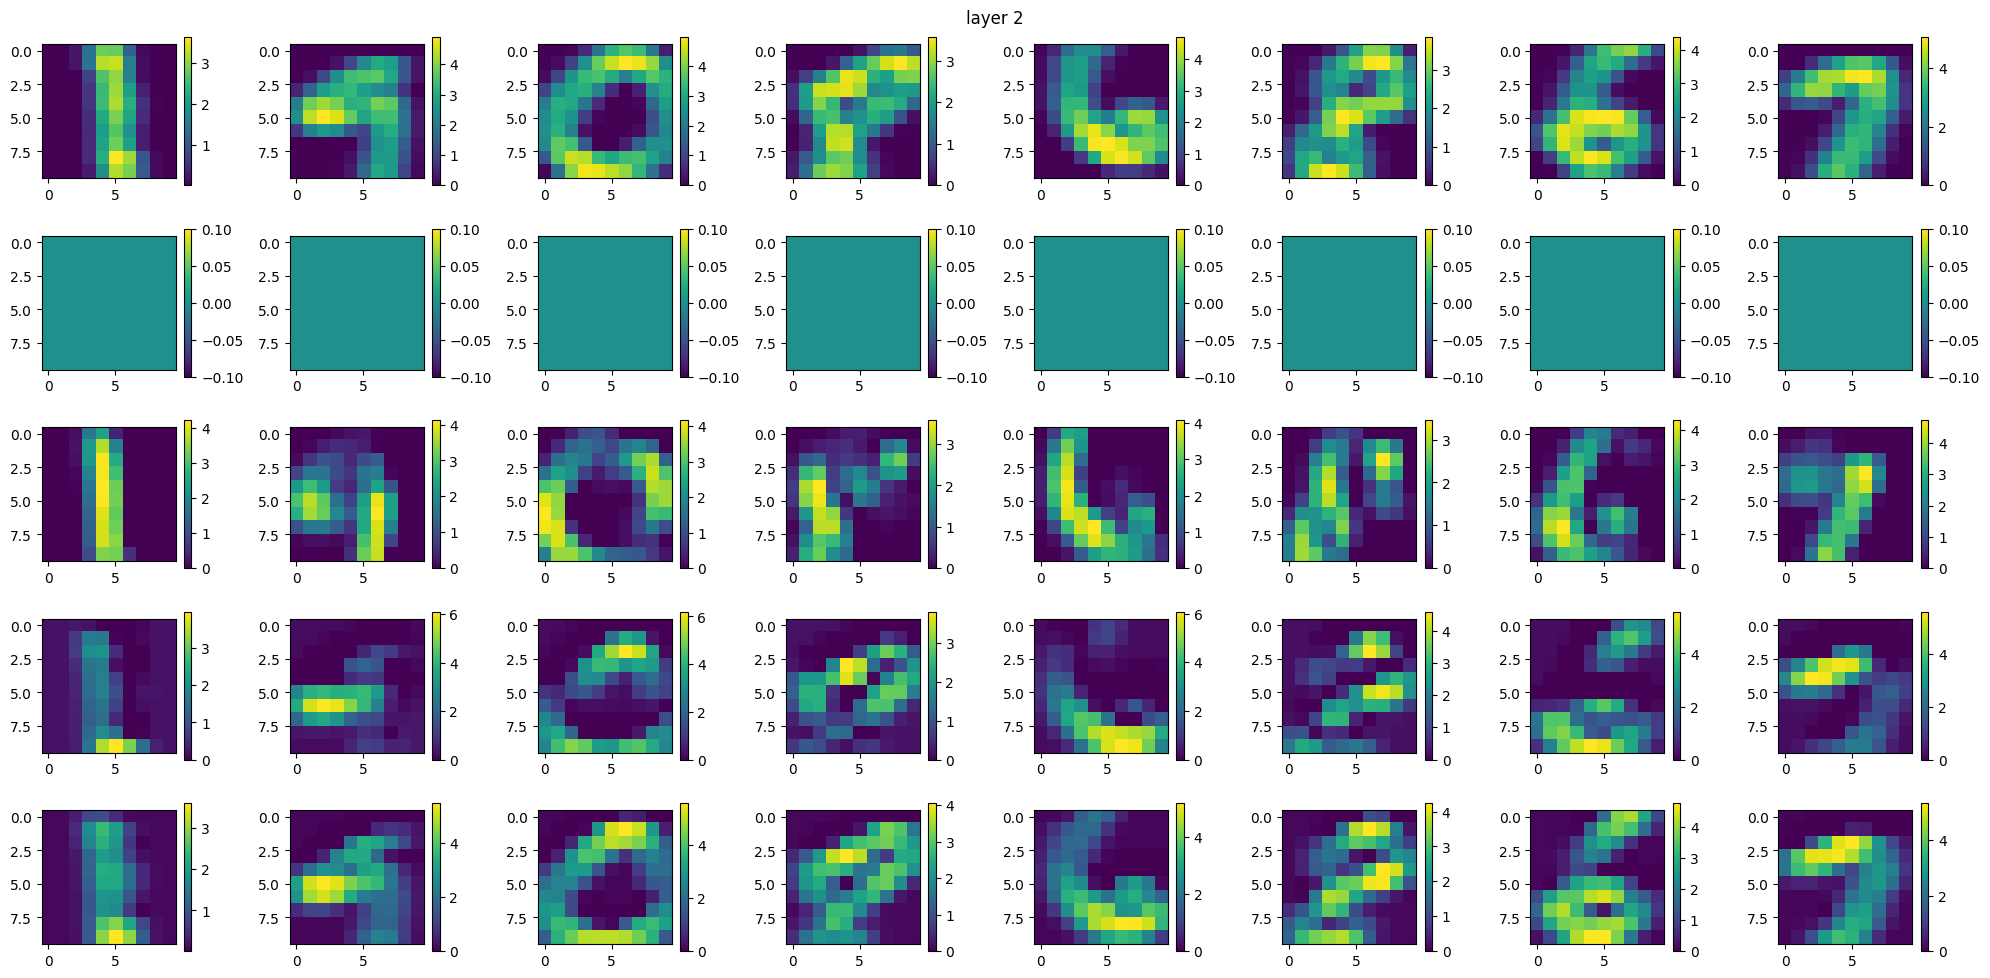

In [105]:
fig, axs = plt.subplots(5, 8, figsize=(20, 10))

plt.suptitle('layer 2')
data = F.relu(F.max_pool2d(model.conv2(data), 2))
for i in range(5):
    for j in range(8):
        ax = axs[i, j]
        sc = ax.imshow(data[j, i].detach().numpy())
        fig.colorbar(sc, ax=ax)
plt.tight_layout()

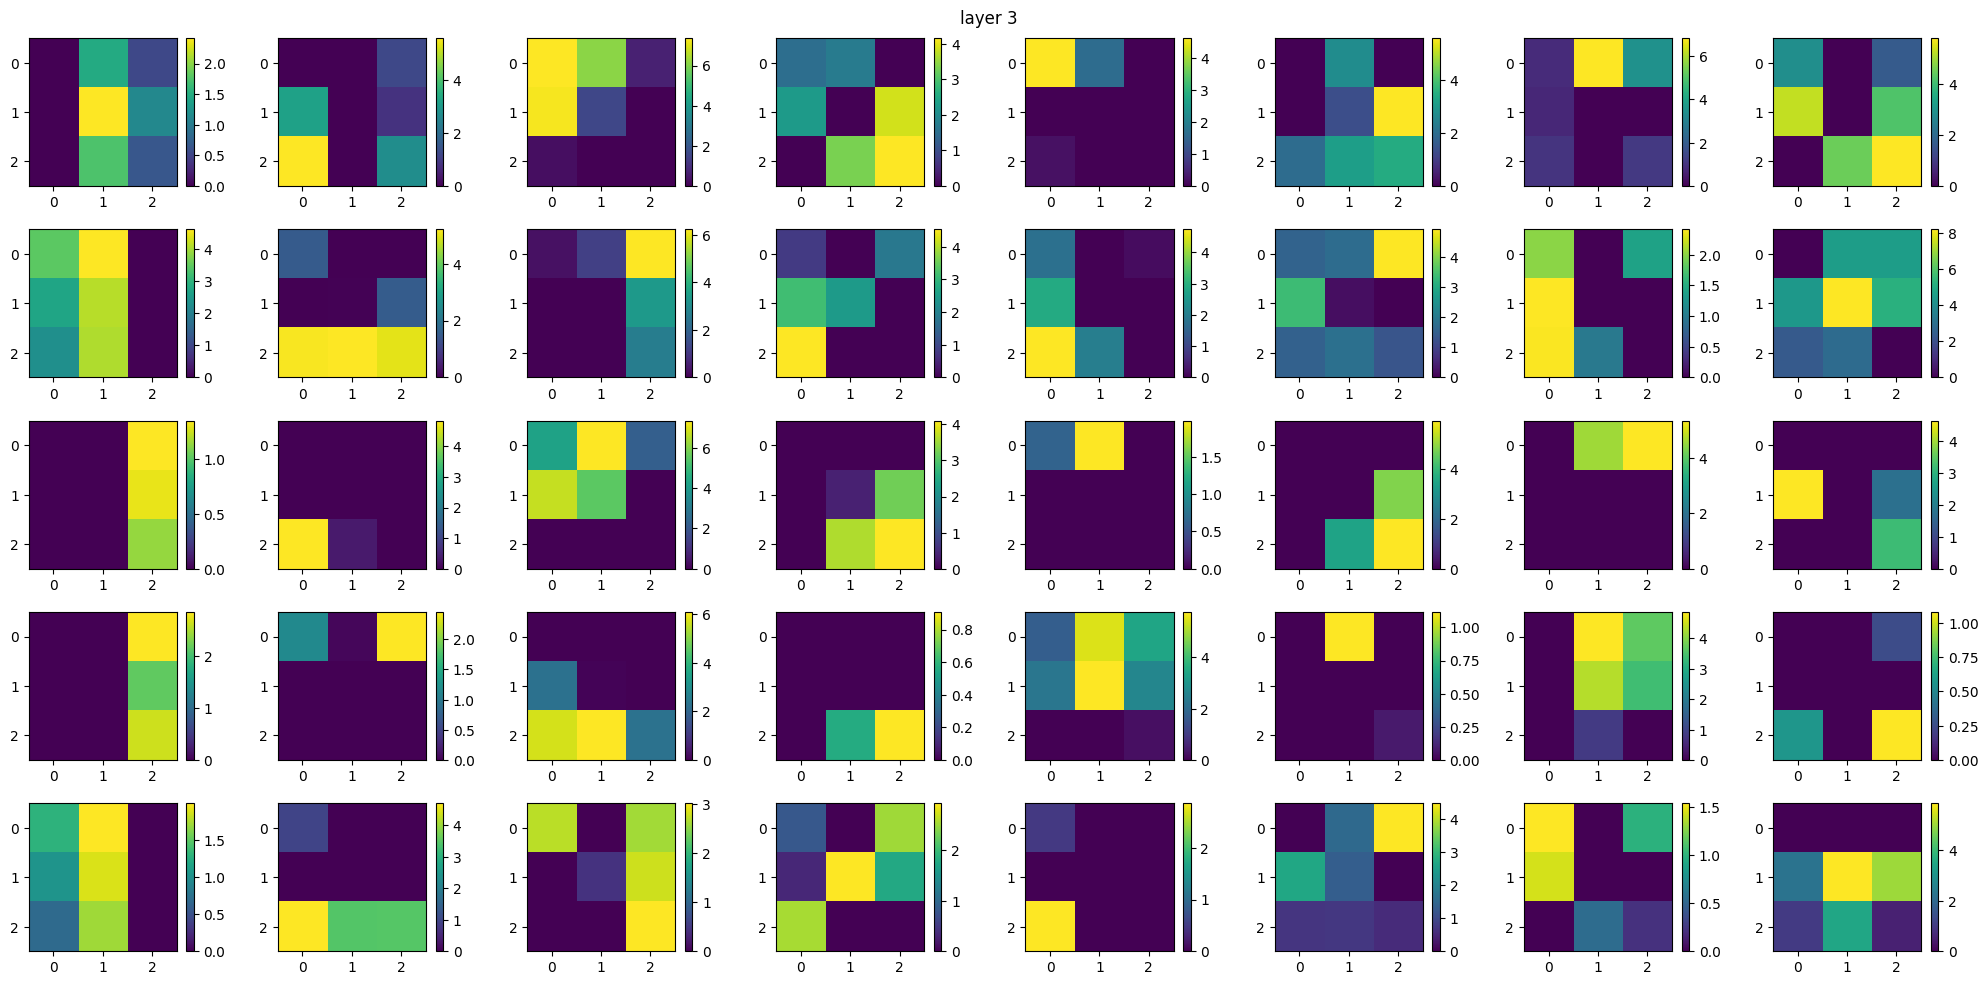

In [106]:
fig, axs = plt.subplots(5, 8, figsize=(20, 10))

plt.suptitle('layer 3')
data = F.relu(F.max_pool2d(model.conv3(data), 2))
for i in range(5):
    for j in range(8):
        ax = axs[i, j]
        sc = ax.imshow(data[j, i].detach().numpy())
        fig.colorbar(sc, ax=ax)
plt.tight_layout()

# Cats and Dogs

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
from timeit import default_timer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
from google.colab.patches import cv2_imshow
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

In [9]:
ROWS = 64
COLS = 64
CHANNELS = 3

In [10]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1jM6FPtWf3rmsfyFTOrPNOgHMkzhAIT8b' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1jM6FPtWf3rmsfyFTOrPNOgHMkzhAIT8b" -O cats_and_dogs.zip && rm -rf /tmp/cookies.txt

--2023-05-04 04:12:26--  https://docs.google.com/uc?export=download&confirm=t&id=1jM6FPtWf3rmsfyFTOrPNOgHMkzhAIT8b
Resolving docs.google.com (docs.google.com)... 74.125.24.138, 74.125.24.100, 74.125.24.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.24.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/l5n07rr70if1ieo9987bgcb1q8u31nk6/1683173475000/13633584189499636757/*/1jM6FPtWf3rmsfyFTOrPNOgHMkzhAIT8b?e=download&uuid=2a2389a0-9ad5-47e4-96ca-ca4c169248b2 [following]
--2023-05-04 04:12:26--  https://doc-0c-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/l5n07rr70if1ieo9987bgcb1q8u31nk6/1683173475000/13633584189499636757/*/1jM6FPtWf3rmsfyFTOrPNOgHMkzhAIT8b?e=download&uuid=2a2389a0-9ad5-47e4-96ca-ca4c169248b2
Resolving doc-0c-5c-docs.googleusercontent.com (doc-0c-5c-docs.googleusercontent.com)... 74.125.200.132, 2404

In [11]:
!unzip -q cats_and_dogs.zip

In [3]:
cats_train_dir = os.path.join('training_set', 'training_set', 'cats')
dogs_train_dir = os.path.join('training_set', 'training_set', 'dogs')

cats_train_fnames = list([os.path.join(cats_train_dir, fname) for fname in os.listdir(cats_train_dir)])
dogs_train_fnames = list([os.path.join(dogs_train_dir, fname) for fname in os.listdir(dogs_train_dir)])

train_fnames = np.random.permutation(cats_train_fnames + dogs_train_fnames)

In [4]:
cats_test_dir = os.path.join('test_set', 'test_set', 'cats')
dogs_test_dir = os.path.join('test_set', 'test_set', 'dogs')

cats_test_fnames = list([os.path.join(cats_test_dir, fname) for fname in os.listdir(cats_test_dir)])
dogs_test_fnames = list([os.path.join(dogs_test_dir, fname) for fname in os.listdir(dogs_test_dir)])

test_fnames = np.random.permutation(cats_test_fnames + dogs_test_fnames)

In [5]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    try:
        result = cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC) 
        # result = result / 255
    except:
        result = None
    return result

In [6]:
def prep_data(images):
    """
    Returns:
        X(n_x, m)
        y(1, m) -- 1: dog, 0: cat
    """
    m = len(images)
    n_x = ROWS * COLS * CHANNELS
    
    X = list()
    y = list()
    # print ("X shape is {}".format(X.shape))
    
    for i in tqdm(range(len(images))):
        image_file = images[i]
        image = read_image(image_file)
        if image is not None:
            X.append(np.squeeze(image.reshape((n_x, 1))))
            if 'dog' in image_file.lower():
                y.append(1)
            elif 'cat' in image_file.lower():
                y.append(-1)
            else:# if neither dog nor cat exist, return the image index (this is the case for test data)
                y.append(0)
        # if i%1000 == 0: print('Processed {} of {}'.format(i, m))
    
    X = np.array(X)
    y = np.array(y)
    print ("X shape is {}".format(X.shape))

    return X, y

In [10]:
X_train, y_train = prep_data(train_fnames)
X_test, y_test = prep_data(test_fnames)

100%|██████████| 8007/8007 [00:25<00:00, 313.93it/s]


X shape is (8005, 12288)


100%|██████████| 2025/2025 [00:05<00:00, 352.57it/s]

X shape is (2023, 12288)


## Sklearn Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

In [12]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

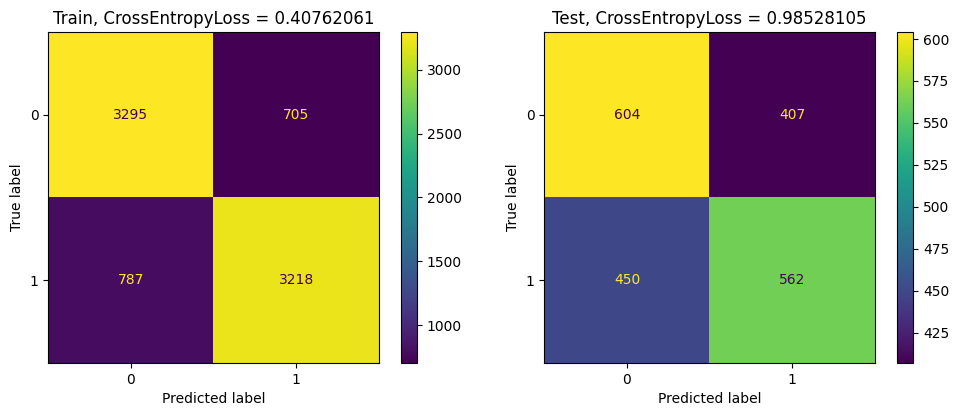

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

y_pred = clf.predict(X_train)
loss = log_loss(y_train, clf.predict_proba(X_train))
cm = confusion_matrix(y_train, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot(ax=axs[0])
axs[0].set_title(f'Train, CrossEntropyLoss = {round(loss, 8)}')

y_pred = clf.predict(X_test)
loss = log_loss(y_test, clf.predict_proba(X_test))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot(ax=axs[1])
axs[1].set_title(f'Test, CrossEntropyLoss = {round(loss, 8)}')

plt.tight_layout()

In [14]:
def plot_roc(clf, ax, title=''):
    if title:
        ax.set_title(title)
    y_score = clf.predict_proba(X_train)
    fpr, tpr, _ = roc_curve(y_train, y_score[:, 1])
    auc_train = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'Train: {round(auc_train, 3)}')
    y_score = clf.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test,  y_score[:, 1])
    auc_test = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'Test: {round(auc_test, 3)}')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.legend()

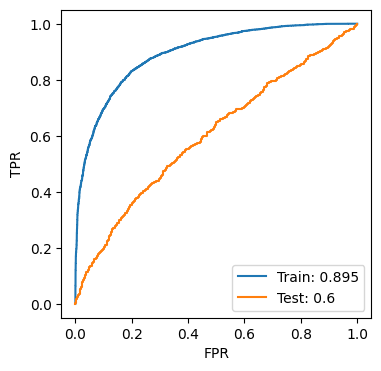

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_roc(clf, ax)

## Convolutional Neural Network

In [82]:
# YOUR CODE HERE